In [50]:
# Modules
import numpy as np
import pandas as pd
import requests
from census import Census
from us import states
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# Census API Key from class and target year for our data
c = Census('85ac64b6b5a9c0901b00329d1ef41f0c53ccfc98', year=2014)

In [3]:
# Make list of target locations using census format
locations = ['003', '510', '013', '550', '041', '059', '650', '087',
             '107', '700', '710', '153', '760', '177', '179', '810']

# Create empty list to store the returned data dictionaries from each location
census_data = []

In [4]:
# Loop API calls for each of the target locations
for loc in locations:
    loc_data = c.acs5.get(('NAME', 'B19013_001E', 'B01003_001E', 'B01002_001E'),
                             {'for': 'county :' + loc , 'in': 'state : 51'})
    
    # Append the consolidated data list with the individual location data
    census_data.append(loc_data)
    
print(census_data)   

[[{'NAME': 'Albemarle County, Virginia', 'B19013_001E': 67958.0, 'B01003_001E': 101883.0, 'B01002_001E': 38.5, 'state': '51', 'county': '003'}], [{'NAME': 'Alexandria city, Virginia', 'B19013_001E': 87319.0, 'B01003_001E': 146422.0, 'B01002_001E': 35.8, 'state': '51', 'county': '510'}], [{'NAME': 'Arlington County, Virginia', 'B19013_001E': 105120.0, 'B01003_001E': 220173.0, 'B01002_001E': 33.8, 'state': '51', 'county': '013'}], [{'NAME': 'Chesapeake city, Virginia', 'B19013_001E': 70176.0, 'B01003_001E': 228168.0, 'B01002_001E': 36.6, 'state': '51', 'county': '550'}], [{'NAME': 'Chesterfield County, Virginia', 'B19013_001E': 72514.0, 'B01003_001E': 324337.0, 'B01002_001E': 38.0, 'state': '51', 'county': '041'}], [{'NAME': 'Fairfax County, Virginia', 'B19013_001E': 112102.0, 'B01003_001E': 1117072.0, 'B01002_001E': 37.4, 'state': '51', 'county': '059'}], [{'NAME': 'Hampton city, Virginia', 'B19013_001E': 49879.0, 'B01003_001E': 136904.0, 'B01002_001E': 35.5, 'state': '51', 'county': '6

In [5]:
# use list comprehension to filter the list of lists which each contain one dict
new_list = [i[0] for i in census_data]

In [6]:
# Turn new list of dicts into data frame
census_data_df = pd.DataFrame.from_dict(new_list)

# Rename wierd census columns
census_data_df.rename(columns={'B01002_001E': 'Median Age', 'B01003_001E': 'Median Household Income',
                               'B19013_001E': 'Population', 'NAME': 'Locale'}, inplace=True)

# Drop redundent columns
census_data_df = census_data_df.drop(['county', 'state'], axis=1)

# Show df
#census_data_df

In [7]:
# Read crime csv data into df
crime_df = pd.read_csv('raw_data/FBI-crime-data_VA_2014.csv')

# Rename the local column
crime_df.rename(columns={'Crime Category': 'Locale'}, inplace=True)

# Drop extra columns
crime_df = crime_df.drop(['Murder and nonnegligent manslaughter', 'Rape', 'Robbery',
                          'Aggravated assault', 'Burglary', 'Larceny-theft',
                          'Motor vehicle theft'], axis=1)

# Show df
#crime_df

In [8]:
# Merge census and crime dfs on Local
census_crime_df = pd.merge(census_data_df, crime_df, how='outer', on='Locale')
#census_crime_df

In [9]:
census_crime_df.dtypes

Median Age                 float64
Median Household Income    float64
Population                 float64
Locale                      object
Violent crime total          int64
Property crime total         int64
dtype: object

In [10]:
census_crime_df['Violent Rate'] = census_crime_df['Violent crime total'] / census_crime_df['Population']

census_crime_df['Property Rate'] = census_crime_df['Property crime total'] / census_crime_df['Population']

#census_crime_df

In [11]:
# Read crime csv data into df
walk_df = pd.read_csv('walk and transit scores.csv')

# Drop extra columns
walk_df = walk_df.drop(['Unnamed: 0', 'transit score'], axis=1)

# Groupby local/area and avg the walk scores
walk_df_mean = walk_df.groupby('Area').mean()

# Show df
#walk_df_mean

In [12]:
walk_df_mean['Locale'] = list(census_crime_df['Locale'])

#walk_df_mean

In [13]:
final_df = pd.merge(census_crime_df, walk_df_mean, how='outer', on='Locale')

# Drop extra columns
final_df = final_df.drop(['lat', 'lon'], axis=1)

# Rename the local column
final_df.rename(columns={'Violent crime total':'Violent Crime Total', 'walk score':'Walk Score',
                         'Property crime total':'Property Crime Total'}, inplace=True)


final_df

,Median Age,Median Household Income,Population,Locale,Violent Crime Total,Property Crime Total,Violent Rate,Property Rate,Walk Score
0,38.5,101883.0,67958.0,"Albemarle County, Virginia",97,1604,0.001427,0.023603,5.32
1,35.8,146422.0,87319.0,"Alexandria city, Virginia",280,2983,0.003207,0.034162,52.63
2,33.8,220173.0,105120.0,"Arlington County, Virginia",314,3521,0.002987,0.033495,62.66
3,36.6,228168.0,70176.0,"Chesapeake city, Virginia",999,6429,0.014236,0.091613,3.63
4,38.0,324337.0,72514.0,"Chesterfield County, Virginia",422,6373,0.005820,0.087886,7.99
5,37.4,1117072.0,112102.0,"Fairfax County, Virginia",969,14603,0.008644,0.130265,54.83
6,35.5,136904.0,49879.0,"Hampton city, Virginia",349,4441,0.006997,0.089035,30.14
7,37.8,314878.0,61438.0,"Henrico County, Virginia",502,7818,0.008171,0.127250,16.43
8,35.1,338916.0,123966.0,"Loudoun County, Virginia",221,2607,0.001783,0.021030,3.38
9,32.7,181362.0,51000.0,"Newport News city, Virginia",782,5552,0.015333,0.108863,27.55


# Crime vs. Walk Score

## Scatter Plot

In [53]:
# If we get pop. density data, we can make this a bubble plot with the 
# size of points correlating with population density.

# Add data to plot for violent crime totals.
violent = plt.scatter(final_df['Walk Score'],
                      final_df['Violent Rate'],
                      label='Violent', color='r', alpha=.8, edgecolor='black')                    

# Add data to plot for property crime totals.
property = plt.scatter(final_df['Walk Score'],
                       final_df['Property Rate'],
                       label='Property', color='b', alpha=.8, edgecolor='black')

# Add a legend in the best location.
plt.legend(handles=[violent, property], loc='best', title='Crime Type', frameon=True)

# Add labels to the x- and y-axes; give the chart a title.
plt.xlabel('Walk Score')
plt.ylabel('Per Capita Crime Rate')
plt.title('Crime Rate vs. Walk Score')

# Set x and y limits.
plt.xlim(0, 70)
plt.ylim(-.01, .3)

# Set the grid background style.
sns.set_style('darkgrid')

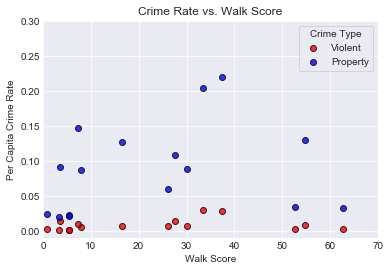

In [54]:
# Save and display plot.
output_path = os.path.join('output', 'crime-rate-vs-walk-score.png')
plt.savefig(output_path, dpi=200)
plt.show()

**Observed Trend**: No relationship between walk score and rate of violent crime, nor rate of property crime. Highest crime rates in both categories occurred for the two locales with walk scores in the mid- to upper-thirties.

## Correlations

In [67]:
# Violent Crime Rate vs. Walk Score
violent_corr = np.corrcoef(final_df['Walk Score'], final_df['Violent Rate'])

# Property Crime Rate vs. Walk Score
property_corr = np.corrcoef(final_df['Walk Score'], final_df['Property Rate'])

# Print results
print('Violent crime rates and property crime rates do not correlate with\
walk scores (r = '+str(violent_corr[0,1])+' and r = '+str(property_corr[0,1])+', \
respectively')

Violent crime rates and property crime rates do not correlate withwalk scores (r = 0.205502014805 and r = 0.226766481968, respectively


**Conclusion:** Violent crime rates and property crime rates do not correlate with walk scores.